Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Vital Signs Data:
    hadm_id  age gender   race language            admittime  \
0  25913397   91      F  WHITE  ENGLISH  2123-09-05T22:48:00   
1  21750724   74      F  WHITE  ENGLISH  2111-10-19T16:20:00   
2  20294147   85      M  WHITE  ENGLISH  2153-08-26T21:40:00   
3  27417164   77      M  WHITE  ENGLISH  2138-10-04T08:16:00   
4  27417164   77      M  WHITE  ENGLISH  2138-10-04T08:16:00   

             dischtime  los  time_to_death    ckd_type  ...  respiration  \
0  2123-09-15T09:45:00  227          227.0  CKD_unkown  ...          3.0   
1  2111-11-05T13:15:00  405            NaN       CKD_3  ...          NaN   
2  2153-09-07T01:40:00  268          268.0  CKD_unkown  ...          4.0   
3  2138-10-20T19:37:00  395            NaN       CKD_3  ...          NaN   
4  2138-10-20T19:37:00  395            NaN       CKD_3  ...          NaN   

   coagulat

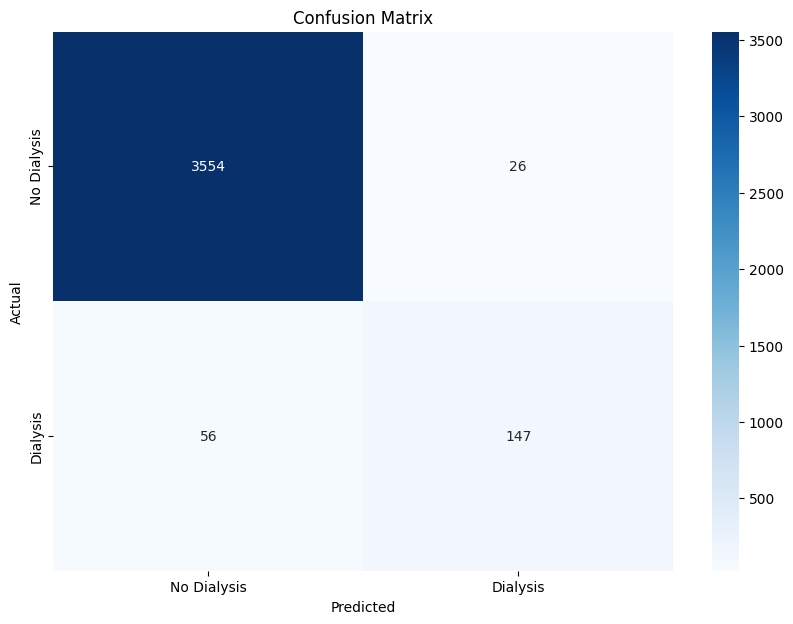

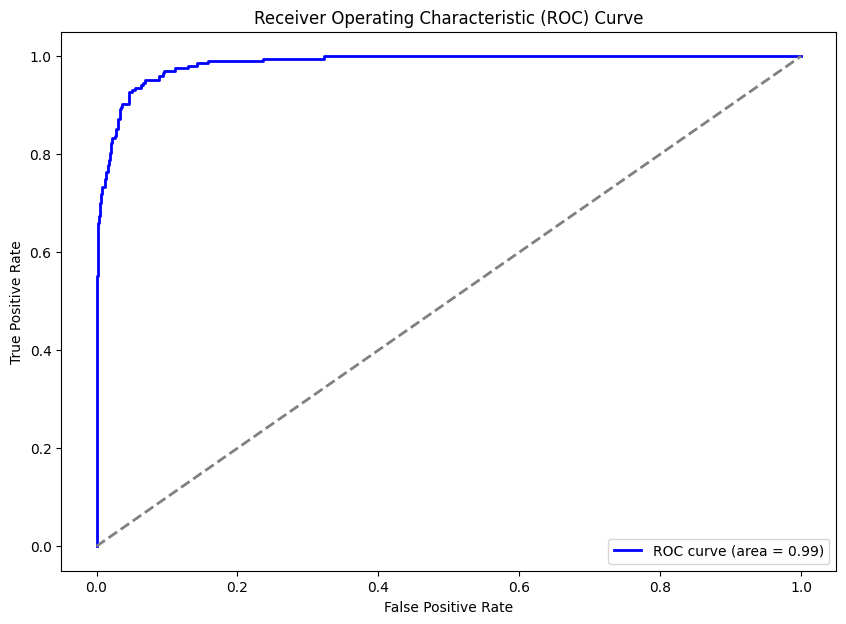

In [3]:
# Install necessary libraries
!pip install pandas scikit-learn seaborn matplotlib xgboost

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import xgboost as xgb

# Mount Google Drive
drive.mount('/content/drive')

# Define the paths to the CSV files in your Google Drive
file_with_vital_signs = '/content/drive/My Drive/with_vital_signs.csv'
file_baseline_with_contrast = '/content/drive/My Drive/baseline_with_contrast.csv'

# Load the CSV files
df_vital_signs = pd.read_csv(file_with_vital_signs)
df_baseline = pd.read_csv(file_baseline_with_contrast)

# Display the first few rows of the datasets to understand their structure
print("Vital Signs Data:")
print(df_vital_signs.head())

print("\nBaseline Data:")
print(df_baseline.head())

# Merge the datasets on hadm_id
df = pd.merge(df_baseline, df_vital_signs, on='hadm_id', suffixes=('_baseline', '_vital'))

# Create a new column 'dialysis_presence' that merges 'crrt_presence' and 'rrt_presence'
df['dialysis_presence'] = df[['crrt_presence_baseline', 'rrt_presence_baseline', 'crrt_presence_vital', 'rrt_presence_vital']].max(axis=1)

# Drop the original columns
df = df.drop(columns=['crrt_presence_baseline', 'rrt_presence_baseline', 'crrt_presence_vital', 'rrt_presence_vital'])

# Fill missing values in numeric columns with the median
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Convert categorical variables to dummy/indicator variables
categorical_columns = ['gender_baseline', 'race_baseline', 'language_baseline', 'ckd_type_baseline', 'contains_contrast_baseline']
for col in categorical_columns:
    if col in df.columns:
        df = pd.get_dummies(df, columns=[col])

# Select relevant features and the target variable
features = [
    'age_baseline', 'los_baseline', 'bun_max', 'creatinine_max', 'SOFA',
    'respiration', 'coagulation', 'liver', 'cardiovascular',
    'cns', 'renal', 'sbp_min', 'mbp_min', 'spo2_min', 'charlson_comorbidity_index'
]

target = 'dialysis_presence'
X = df[features]
y = df[target].astype(int)  # Ensure the target variable is of integer type

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Dialysis', 'Dialysis'], yticklabels=['No Dialysis', 'Dialysis'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      3580
           1       0.27      0.72      0.40       203

    accuracy                           0.88      3783
   macro avg       0.63      0.81      0.66      3783
weighted avg       0.94      0.88      0.91      3783

Confusion Matrix:
[[3186  394]
 [  56  147]]


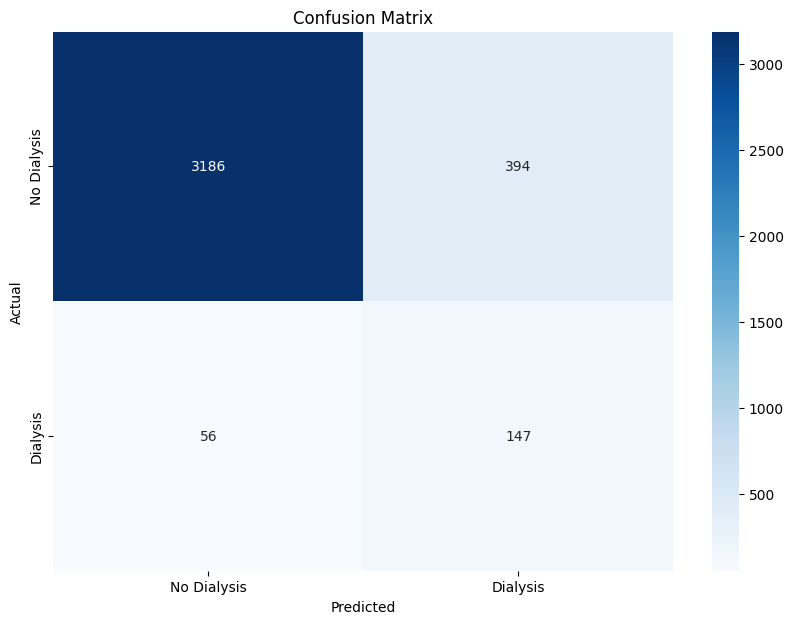

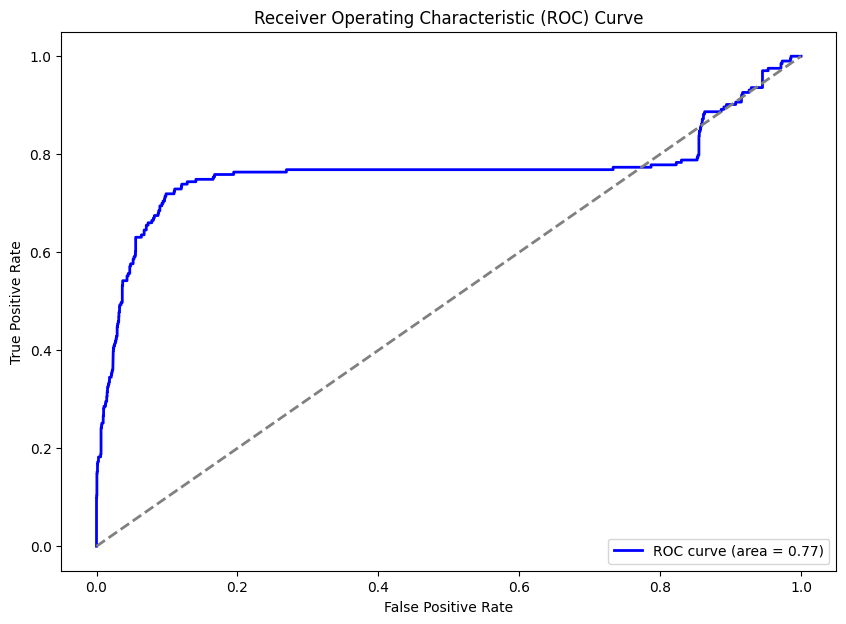

In [2]:
# Install necessary libraries
!pip install pandas scikit-learn seaborn matplotlib

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the paths to the CSV files in your Google Drive
file_with_vital_signs = '/content/drive/My Drive/with_vital_signs.csv'
file_baseline_with_contrast = '/content/drive/My Drive/baseline_with_contrast.csv'

# Load the CSV files
df_vital_signs = pd.read_csv(file_with_vital_signs)
df_baseline = pd.read_csv(file_baseline_with_contrast)

# Merge the datasets on hadm_id
df = pd.merge(df_baseline, df_vital_signs, on='hadm_id', suffixes=('_baseline', '_vital'))

# Create a new column 'dialysis_presence' that merges 'crrt_presence' and 'rrt_presence'
df['dialysis_presence'] = df[['crrt_presence_baseline', 'rrt_presence_baseline', 'crrt_presence_vital', 'rrt_presence_vital']].max(axis=1)

# Drop the original columns
df = df.drop(columns=['crrt_presence_baseline', 'rrt_presence_baseline', 'crrt_presence_vital', 'rrt_presence_vital'])

# Fill missing values in numeric columns with the median
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Convert categorical variables to dummy/indicator variables
categorical_columns = ['gender_baseline', 'race_baseline', 'language_baseline', 'ckd_type_baseline', 'contains_contrast_baseline']
for col in categorical_columns:
    if col in df.columns:
        df = pd.get_dummies(df, columns=[col])

# Select relevant features and the target variable
features = [
    'age_baseline', 'los_baseline', 'bun_max', 'creatinine_max', 'SOFA',
    'respiration', 'coagulation', 'liver', 'cardiovascular',
    'cns', 'renal', 'sbp_min', 'mbp_min', 'spo2_min', 'charlson_comorbidity_index'
]

target = 'dialysis_presence'
X = df[features]
y = df[target].astype(int)  # Ensure the target variable is of integer type

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use a subset of the data for initial testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train the SVM classifier
svm = SVC(kernel='linear', probability=True, max_iter=1000)
svm.fit(X_train, y_train)

# Make predictions
y_pred = svm.predict(X_test)
y_pred_prob = svm.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Dialysis', 'Dialysis'], yticklabels=['No Dialysis', 'Dialysis'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
